# Decision Tree Model with One Hot Encoder for Categorical Variables

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [5]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [59]:
data = loan_approval_lib.load_original_data()

In [62]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


# Data Cleaning

In [61]:
columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_default_on_file'
]

for column in columns:
    row_count_1 = len(data)

    if column == 'person_age':
        data = data[data['person_age'] <= 100]

    if column == 'person_emp_length':
        data = data[data['person_emp_length'] <= 100]

    data = data[data[column].isna() == False]
    
    row_count_2 = len(data)
    row_count_diff = row_count_1 - row_count_2
    print(f'column {column}, number of removed rows: {row_count_diff}')
    

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


# Loan Grade

In [63]:
loan_grades = list(sorted(data['loan_grade'].unique()))

for loan_grade in loan_grades:
    data.loc[data['loan_grade'] == loan_grade, 'loan_grade_numerical'] = ord(loan_grade) - ord('A')

In [64]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,1.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,2.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,2.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,2.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0,2.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1,1.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0,1.0


# Person Home Ownership

In [65]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(data[['person_home_ownership']])
transformed = encoder.transform(data[['person_home_ownership']])

data = pandas.concat(
    [
        data,
        pandas.DataFrame(
            transformed,
            index=data.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['person_home_ownership']),
        ),
    ],
    axis=1,
)

data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_grade_numerical,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,1.0,0.0,0.0,1.0,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,2.0,1.0,0.0,0.0,0.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,2.0,0.0,0.0,0.0,1.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,2.0,0.0,0.0,0.0,1.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0,2.0,1.0,0.0,0.0,0.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0,0.0,1.0,0.0,0.0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1,1.0,0.0,0.0,0.0,1.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0,1.0,1.0,0.0,0.0,0.0


In [39]:
encoder.categories_

[array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object)]

In [46]:
encoder.get_feature_names_out(['person_home_ownership'])

array(['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT'],
      dtype=object)

In [43]:
encoder.transform(
    [['MORTGAGE'], ['OTHER'], ['OWN'], ['RENT']]
).toarray()

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

# Loan Intent

In [66]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(data[['loan_intent']])
transformed = encoder.transform(data[['loan_intent']])

data = pandas.concat(
    [
        data,
        pandas.DataFrame(
            transformed,
            index=data.index,
            #columns = [f'person_home_ownership_{category}' for category in encoder.categories_],
            columns=encoder.get_feature_names_out(['loan_intent']),
        ),
    ],
    axis=1,
)

data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Default on File

In [67]:
data.loc[data['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data.loc[data['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

data['cb_person_default_on_file_predict'] = data['cb_person_default_on_file_vote'].map(lambda x: 0 if x == -1 else 1)

In [68]:
(data['loan_status'] == data['cb_person_default_on_file_predict']).sum() / len(data)

np.float64(0.739731768650461)

# Choose Columns for Tree Model

In [70]:
for column in data.columns:
    print(column)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_numerical
person_home_ownership_MORTGAGE
person_home_ownership_OTHER
person_home_ownership_OWN
person_home_ownership_RENT
loan_intent_DEBTCONSOLIDATION
loan_intent_EDUCATION
loan_intent_HOMEIMPROVEMENT
loan_intent_MEDICAL
loan_intent_PERSONAL
loan_intent_VENTURE
cb_person_default_on_file_vote
cb_person_default_on_file_predict


In [75]:
decision_tree_columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'loan_grade_numerical',
    'person_home_ownership_MORTGAGE',
    'person_home_ownership_OTHER',
    'person_home_ownership_OWN',
    'person_home_ownership_RENT',
    'loan_intent_DEBTCONSOLIDATION',
    'loan_intent_EDUCATION',
    'loan_intent_HOMEIMPROVEMENT',
    'loan_intent_MEDICAL',
    'loan_intent_PERSONAL',
    'loan_intent_VENTURE',
    'cb_person_default_on_file_vote',
]

In [76]:
X = data[decision_tree_columns].copy()
Y = data['loan_status'].copy()

# Decision Tree Model - Max Depth 1

In [77]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = clf.fit(X, Y)

In [78]:
Z = clf.predict(X)

In [79]:
data['loan_status_tree_predict'] = Z

In [81]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8317267393126572)

In [80]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_percent_income               1.0
person_income                     0.0
person_age                        0.0
person_emp_length                 0.0
loan_amnt                         0.0
loan_int_rate                     0.0
cb_person_cred_hist_length        0.0
loan_grade_numerical              0.0
person_home_ownership_MORTGAGE    0.0
person_home_ownership_OTHER       0.0
person_home_ownership_OWN         0.0
person_home_ownership_RENT        0.0
loan_intent_DEBTCONSOLIDATION     0.0
loan_intent_EDUCATION             0.0
loan_intent_HOMEIMPROVEMENT       0.0
loan_intent_MEDICAL               0.0
loan_intent_PERSONAL              0.0
loan_intent_VENTURE               0.0
cb_person_default_on_file_vote    0.0
dtype: float64


In [82]:
# Same as before, which is not surprising, since the previous max depth 1 decision tree model also trained on this single numerical variable

# Decision Tree Model - Max Depth 2

In [84]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf = clf.fit(X, Y)

In [85]:
Z = clf.predict(X)

In [86]:
data['loan_status_tree_predict'] = Z

In [87]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8726599608829282)

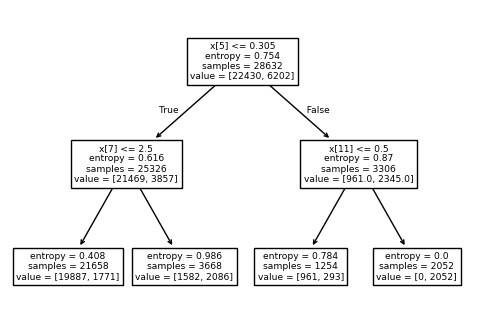

In [88]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-numerical-onehot-2.pdf')
plt.savefig('tree-max-depth-numerical-onehot-2.png')
plt.show()

In [89]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_grade_numerical              0.384102
loan_percent_income               0.383549
person_home_ownership_RENT        0.232348
person_emp_length                 0.000000
person_income                     0.000000
person_age                        0.000000
loan_int_rate                     0.000000
cb_person_cred_hist_length        0.000000
person_home_ownership_MORTGAGE    0.000000
person_home_ownership_OTHER       0.000000
loan_amnt                         0.000000
person_home_ownership_OWN         0.000000
loan_intent_DEBTCONSOLIDATION     0.000000
loan_intent_EDUCATION             0.000000
loan_intent_HOMEIMPROVEMENT       0.000000
loan_intent_MEDICAL               0.000000
loan_intent_PERSONAL              0.000000
loan_intent_VENTURE               0.000000
cb_person_default_on_file_vote    0.000000
dtype: float64


- Very similar result, but marginally lower accuracy
- This is not surprising since the previous model differed only by including `person_home_ownership` 'OTHER' in the `+1` category, whereas here it is separated from 'RENT'

In [90]:
for index, column in enumerate(decision_tree_columns):
    print(f'index={index} column={column}')

index=0 column=person_age
index=1 column=person_income
index=2 column=person_emp_length
index=3 column=loan_amnt
index=4 column=loan_int_rate
index=5 column=loan_percent_income
index=6 column=cb_person_cred_hist_length
index=7 column=loan_grade_numerical
index=8 column=person_home_ownership_MORTGAGE
index=9 column=person_home_ownership_OTHER
index=10 column=person_home_ownership_OWN
index=11 column=person_home_ownership_RENT
index=12 column=loan_intent_DEBTCONSOLIDATION
index=13 column=loan_intent_EDUCATION
index=14 column=loan_intent_HOMEIMPROVEMENT
index=15 column=loan_intent_MEDICAL
index=16 column=loan_intent_PERSONAL
index=17 column=loan_intent_VENTURE
index=18 column=cb_person_default_on_file_vote


# Decision Tree Model - No Max Depth

In [92]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

In [93]:
Z = clf.predict(X)

In [94]:
data['loan_status_tree_predict'] = Z

In [95]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(1.0)

In [96]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_percent_income               0.192470
loan_grade_numerical              0.163417
person_income                     0.151396
person_home_ownership_RENT        0.122385
loan_int_rate                     0.070147
person_emp_length                 0.062922
person_age                        0.048228
loan_amnt                         0.045340
cb_person_cred_hist_length        0.027243
loan_intent_MEDICAL               0.023213
person_home_ownership_OWN         0.022517
loan_intent_DEBTCONSOLIDATION     0.021365
loan_intent_VENTURE               0.011505
loan_intent_HOMEIMPROVEMENT       0.011438
person_home_ownership_MORTGAGE    0.008062
loan_intent_EDUCATION             0.007463
loan_intent_PERSONAL              0.006082
cb_person_default_on_file_vote    0.004261
person_home_ownership_OTHER       0.000547
dtype: float64
